In [232]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import src.plots
from src.utils import parse_lipid, parse_p_value
from src.plots import plot_quant_vs_ogtt, tight_bbox
importlib.reload(src.plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [632]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

cd = pd.read_excel('../data/raw/metabolomics/validation/Nilerat_validation_metabs_manual_filtering.xlsx')

## Map CD's long column name to short col name

In [539]:
cols = cd.filter(regex='^Area: ').columns
split_cols = [col.split(' ')[1][:-4] for col in cols]
split_cols
rename = {col: new for col, new in zip(cols, split_cols) if new in fg['File Name_metab'].values}
rename2 = {}
for key, value in rename.items():
    short = fg.loc[fg['File Name_metab'] == value].index[0]
#     print(short)
    rename2[key] = short
rename2
cd.rename(rename2, axis=1, inplace=True)
cd

,ID,in_original,is_lipid,is_junk,is_dubious,Annot. DeltaMass [ppm],Calc. MW,m/z,RT,adduct,...,Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC50uL_dil.raw (F65),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_dil.raw (F66),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep1.raw (F67),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep2.raw (F68),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep3.raw (F69),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep4.raw (F70),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC150uL_dil.raw (F71),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC200uL_dil.raw (F72),Peak Rating: BJA-Nilerat-20220921_metab_1000s_water_blank_rep1.raw (F73),Peak Rating: BJA-Nilerat-20220921_metab_resuspension_blank_rep1.raw (F92)
0,NaN,NaN,NaN,NaN,NaN,NaN,84.03107,83.02379,0.240,[M-H]-1,...,0.7,0.7,0.9,2.4,5.5,0.7,3.2,5.5,0.9,0.9
1,NaN,NaN,1.0,NaN,NaN,-4.18,510.33875,509.33147,1.300,[M-H]-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,-1.17,368.34387,369.35115,1.329,[M+H]+1,...,4.5,5.6,3.3,4.7,4.8,5.6,5.6,2.2,NaN,0.5
3,NaN,NaN,1.0,NaN,NaN,NaN,871.76122,872.76849,1.330,[M+H]+1,...,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cholesterol sulfate,NaN,1.0,NaN,NaN,1.63,466.31244,465.30516,1.389,[M-H]-1,...,3.6,0.9,6.2,5.5,5.8,3.9,3.9,5.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,NaN,NaN,NaN,NaN,NaN,1.25,228.10861,227.10133,18.268,[M-H]-1,...,2.7,2.7,2.7,0.5,2.7,4.2,0.5,0.7,NaN,NaN
432,NaN,NaN,NaN,NaN,NaN,NaN,146.10463,145.09734,18.271,[M-H]-1,...,4.8,5.2,4.5,4.8,4.8,5.2,5.2,5.8,NaN,NaN
433,Arginine,1.0,NaN,NaN,NaN,-0.56,174.11158,175.11894,18.711,[M+H]+1,...,0.5,0.5,0.5,0.5,0.5,4.2,4.5,4.5,NaN,0.2
434,NaN,1.0,NaN,NaN,NaN,-8.00,132.08882,131.08154,18.724,[M-H]-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Remove those I labeled as lipids

In [541]:
cd['is_lipid'] = cd['is_lipid'].replace(np.nan, 0).astype('bool')
cd = cd.loc[~(cd['is_lipid'])]

## remove all features > 300 m/z to clean up most of the in-source frag impurities 

In [542]:
cd = cd.loc[cd['m/z'] < 300]

# remove features that are rsd > 60% because those are likely automatically bad

<AxesSubplot:>

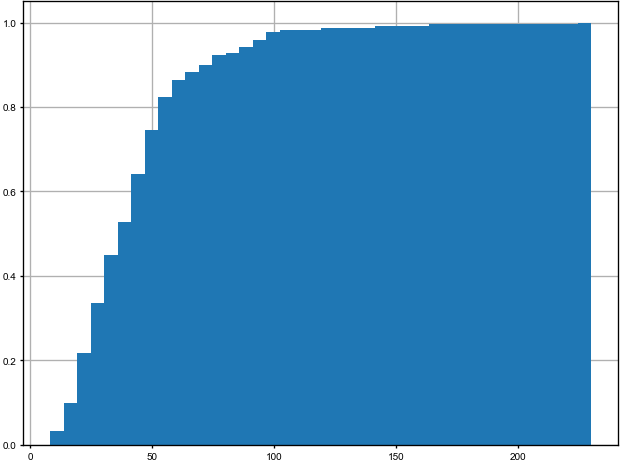

In [543]:
qcfiles = fg.loc[fg['animal'] == 'qc'].index

cd['qc_rsd'] = cd[qcfiles].std(axis=1) / cd[qcfiles].mean(axis=1) * 100

cd['qc_rsd'].hist(bins=40, cumulative=True, density=True)
cd = cd.loc[cd['qc_rsd'] < 60]

# remove features with mean intensity < 3x blank

In [547]:
cd['max_blank'] = cd.loc[:, fg.loc[fg['animal'].str.contains('blank')].index].max(axis=1)
cd['mean_quant'] = cd.loc[:, fg.loc[fg['validation']].index].mean(axis=1)
cd = cd.loc[cd['mean_quant'] > 3*cd['max_blank']]

# Initial assessment of samples

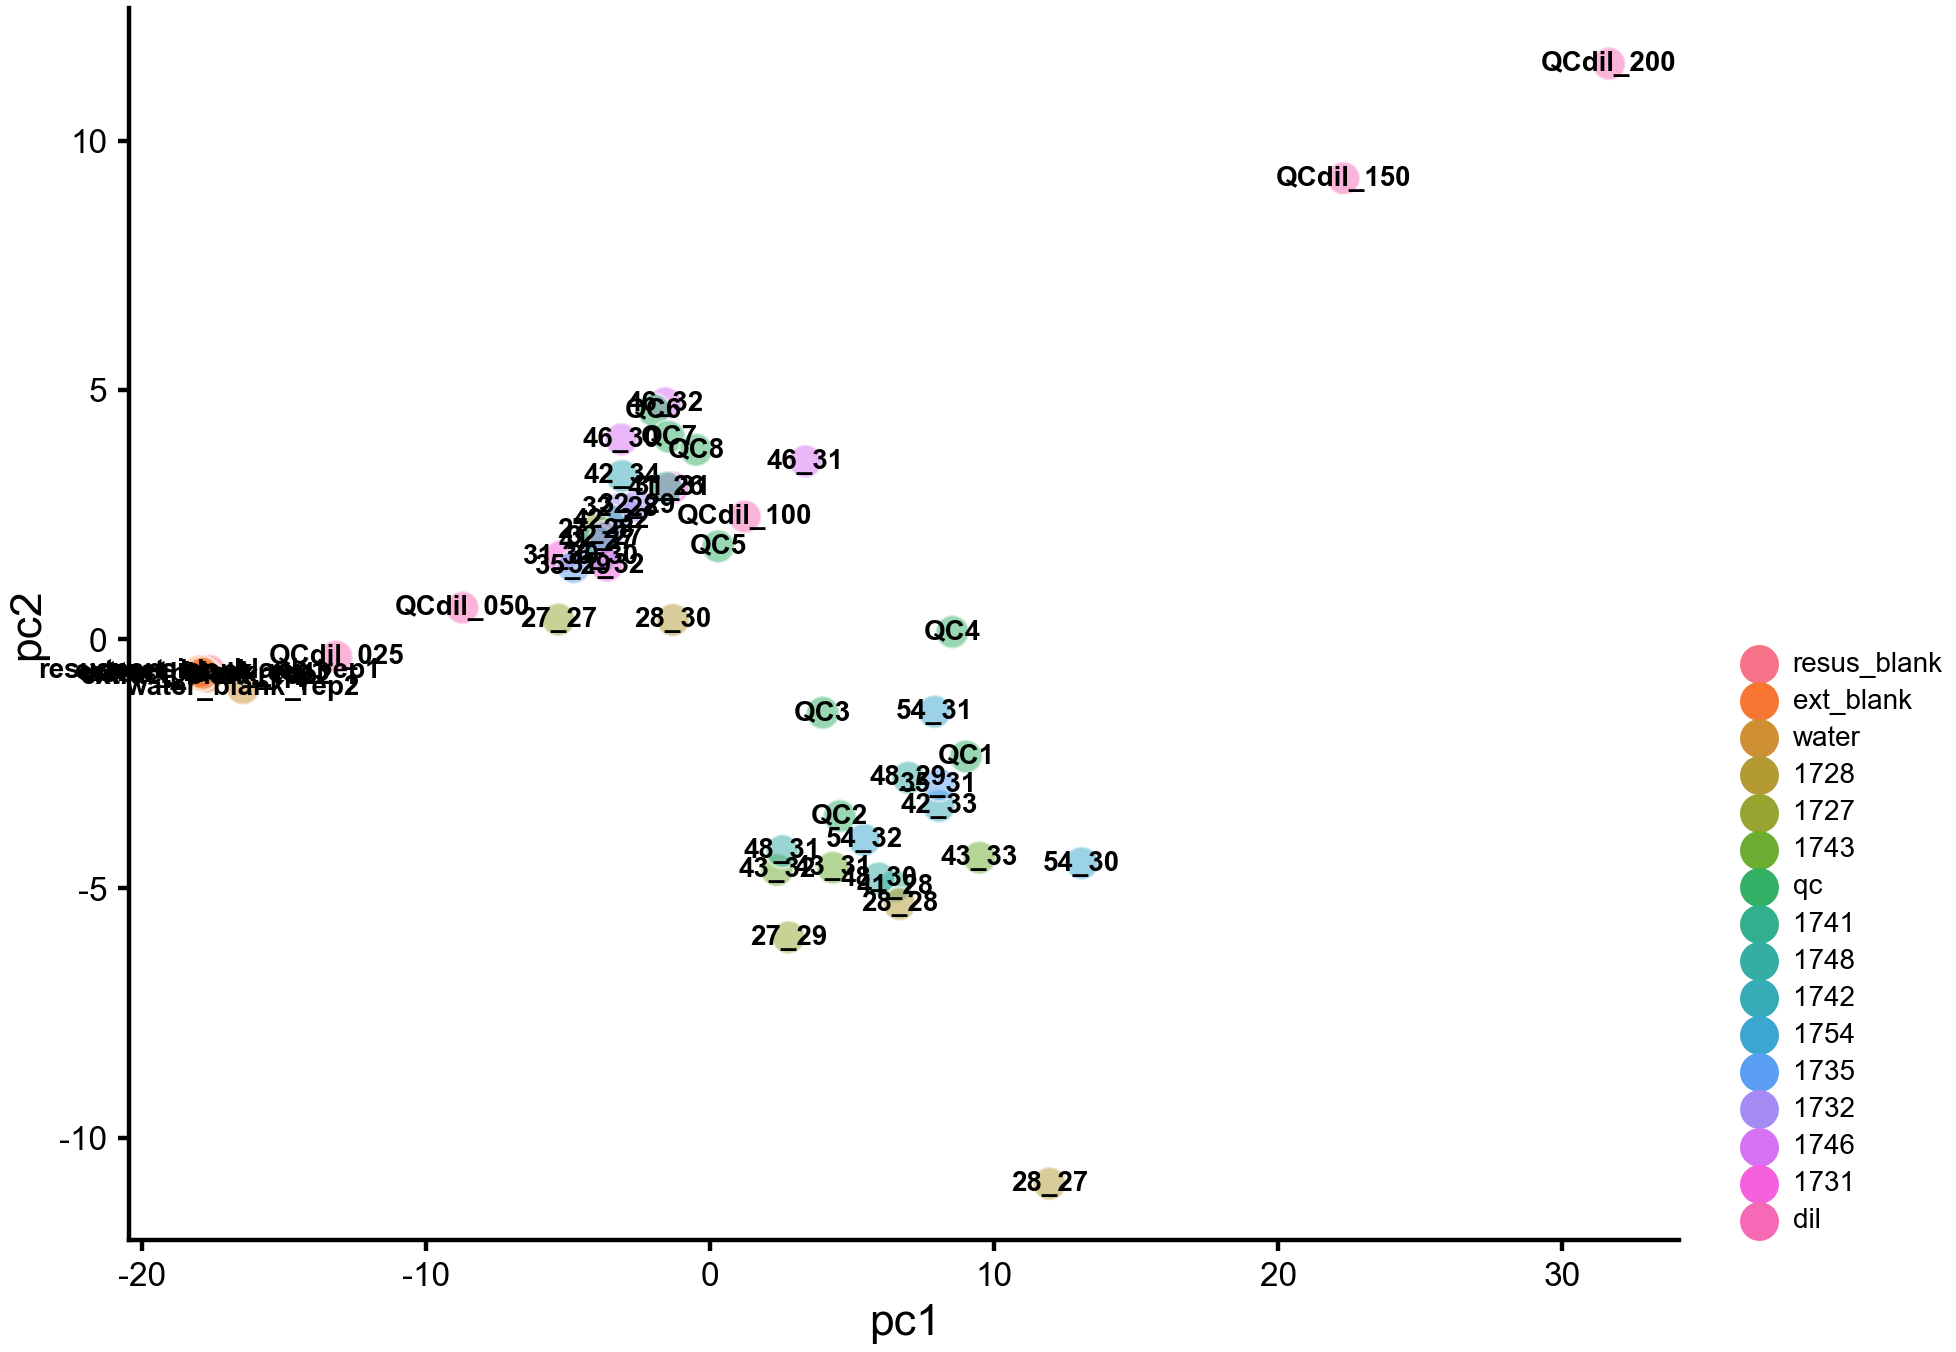

In [563]:
files = fg.loc[(fg['cohort'] == '30wk') & \
               (fg['ogtt'].notna() 
                | fg['qc_rep'] 
                | fg['qc_dilution'] 
                | fg['blank_file']
               )
              ].index

df = cd.loc[:, files].T
# df = cd.loc[cd['ID'].notna(), files].T
df = pd.DataFrame(StandardScaler().fit_transform(df.values), index=df.index, columns=df.columns)
pca = pd.DataFrame(PCA(n_components=10).fit_transform(df), 
                   index=df.index, columns=[f'pc{x}' for x in range(1, 11)])
pca = pca.join(fg[['animal', 'metab_run_order']])
pca = pca.sort_values('metab_run_order')

pcx = 'pc1'
pcy = 'pc2'
fig, ax = plt.subplots(dpi=400, figsize=(5, 4))
sns.scatterplot(
    data=pca, x=pcx, y=pcy, hue='animal', ax=ax, 
    alpha=0.5
)

prevx, prevy = 0, 0
for i, row in pca.iterrows():
    if 'RBG' in i:
#         continue
        i = i[2:7]
#         ax.plot((prevx, row[pcx]), (prevy, row[pcy]), color='gray', zorder=-10)
#         prevx, prevy = row[pcx], row[pcy]
    if '1700s' in i:
        i = i[6:]
    ax.text(row[pcx], row[pcy], i, ha='center', va='center', fontsize=5, fontweight='bold')
    
ax.legend(loc=(1.03, 0), fontsize=5)
sns.despine()

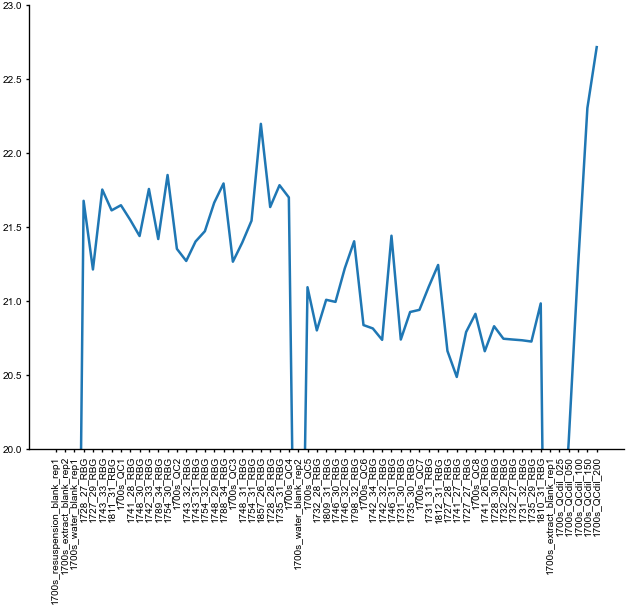

In [564]:
sorted_runs = fg.loc[fg['second_runs'], ['metab_run_order']].sort_values('metab_run_order')
run_order = sorted_runs.index[:59]

romeds = np.log2(cd.loc[:, run_order]).median()
plt.plot(range(len(romeds)), romeds)
plt.xticks(range(len(romeds)), romeds.index, rotation=90)
plt.ylim(20, 23)
sns.despine()


# Clearly there is a batch effect that occured after QC4
# This is apparent from the PCA, the median file intensity for all files and the median QC rep 

## It is possible to create a function that normalizes the median intensity via interpolation between median QC intensities 

## Or median center all files

# Interpolation method:
## Use the QC medians to create a piecewise function that can do a median adjustment 

,metab_run_order,center,interpolated,interpolation norm
1700s_resuspension_blank_rep1,1,21.139046,21.648321,-0.509274
1700s_extract_blank_rep2,2,21.139046,21.648321,-0.509274
1700s_water_blank_rep1,3,21.139046,21.648321,-0.509274
1728_27_RBG,4,21.139046,21.648321,-0.509274
1727_29_RBG,5,21.139046,21.648321,-0.509274
1743_33_RBG,6,21.139046,21.648321,-0.509274
1811_31_RBG,7,21.139046,21.648321,-0.509274
1700s_QC1,8,21.139046,21.648321,-0.509274
1741_28_RBG,9,21.139046,21.592388,-0.453342
1748_30_RBG,10,21.139046,21.536456,-0.397409


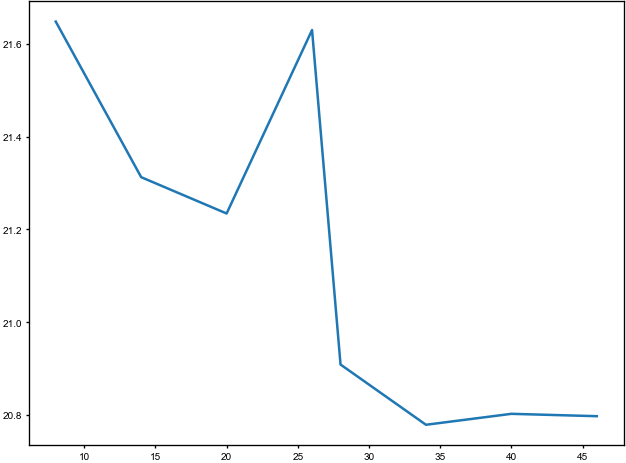

In [565]:
qc_run_number = sorted_runs.loc[fg.loc[fg['animal'] == 'qc'].index, 'metab_run_order']
qcmedians = log2qc.median()

plt.plot(qc_run_number, qcmedians)

interp = np.interp(x=range(1, len(sorted_runs) + 1), xp=qc_run_number, fp=qcmedians, 
                   left=qcmedians[0], right=qcmedians[1])
center = qcmedians.mean()

sorted_runs['center'] = center
sorted_runs['interpolated'] = interp
sorted_runs['interpolation norm'] = sorted_runs['center'] - sorted_runs['interpolated']
sorted_runs.iloc[:50]

In [566]:
qcmedians + sorted_runs.loc[qcmedians.index, 'interpolation norm']

1700s_QC1    21.139046
1700s_QC2    21.139046
1700s_QC3    21.139046
1700s_QC4    21.139046
1700s_QC5    21.139046
1700s_QC6    21.139046
1700s_QC7    21.139046
1700s_QC8    21.139046
dtype: float64

In [567]:
all_files = fg.loc[fg['validation'] | (fg['animal'] == 'qc')].index
all_files = sorted_runs.loc[all_files].sort_values('metab_run_order').index
all_files

Index(['1728_27_RBG', '1727_29_RBG', '1743_33_RBG', '1700s_QC1', '1741_28_RBG',
       '1748_30_RBG', '1742_33_RBG', '1754_30_RBG', '1700s_QC2', '1743_32_RBG',
       '1743_31_RBG', '1754_32_RBG', '1748_29_RBG', '1700s_QC3', '1748_31_RBG',
       '1754_31_RBG', '1728_28_RBG', '1735_31_RBG', '1700s_QC4', '1700s_QC5',
       '1732_28_RBG', '1746_30_RBG', '1746_32_RBG', '1700s_QC6', '1742_34_RBG',
       '1742_32_RBG', '1746_31_RBG', '1731_30_RBG', '1735_30_RBG', '1700s_QC7',
       '1731_31_RBG', '1727_28_RBG', '1741_27_RBG', '1727_27_RBG', '1700s_QC8',
       '1741_26_RBG', '1728_30_RBG', '1732_29_RBG', '1732_27_RBG',
       '1731_32_RBG', '1735_29_RBG'],
      dtype='object')

28.9915597841283

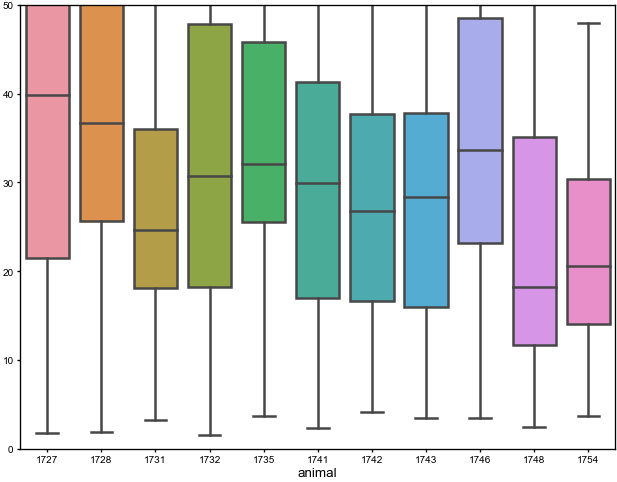

In [604]:
log2quants = np.log2(cd.loc[:, all_files])
interp_norm = log2quants.add(sorted_runs.loc[all_files, 'interpolation norm'])
interp_norm

cdinterp = cd.copy()

cdinterp.loc[:, all_files] = np.power(2, interp_norm)
cdinterp


gbinterp = cdinterp.loc[:, fg.loc[fg['validation']].index].T.groupby(fg['animal'])
interprsd = ((gbinterp.std() / gbinterp.mean()) * 100)
sns.boxplot(data=interprsd.T)
plt.ylim(0, 50)
np.median(interprsd.values.ravel())

# Median centering

24.621775049086303

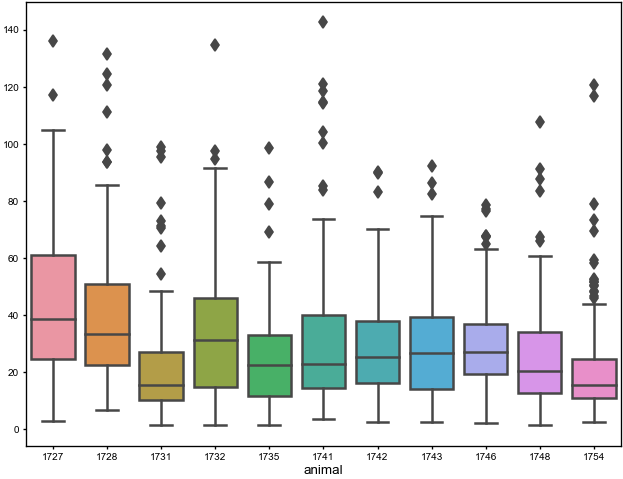

In [605]:
log2quants = np.log2(cd.loc[:, all_files])
file_medians = log2quants.median()
center = file_medians.mean()
norm_factor = center - file_medians 
# log2quants
centered = log2quants.add(norm_factor, axis=1)
centered = np.power(2, centered)
centered

cdcent = cd.copy()
cdcent.loc[:, all_files] = centered
cdcent

gbcent = cdcent.loc[:, fg.loc[fg['validation']].index].T.groupby(fg['animal'])
centrsd = ((gbcent.std() / gbcent.mean()) * 100)
sns.boxplot(data=centrsd.T)
# plt.ylim(0, 50)
np.median(centrsd.values.ravel())

In [612]:
centrsd.median(axis=1)

animal
1727    38.562890
1728    33.336125
1731    15.504138
1732    31.198330
1735    22.405632
1741    22.693006
1742    25.203626
1743    26.689934
1746    27.126147
1748    20.561506
1754    15.622290
dtype: float64

# Calculate RSDs for features based on 8 QC files

In [593]:
random_feature = cdcent.sample(1).index

qcfiles = fg.loc[fg['animal'] == 'qc'].index

sample = cdcent.loc[random_feature, qcfiles]
sample.std(axis=1) / sample.mean(axis=1) * 100

180    31.161454
dtype: float64

35.802439074163914

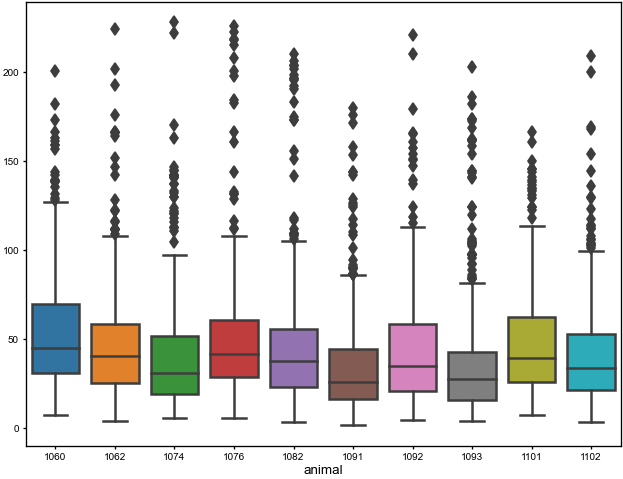

In [609]:
datagb = (np.power(2, data.loc[data['Type'] == 'metabolite', data_cols])
          .T
          .groupby(fg['animal'])
         )
datarsd = (datagb.std() / datagb.mean()) * 100  
sns.boxplot(data=datarsd.T)
# datarsd.median(axis=1).mean()
np.median(datarsd.values.ravel())

In [610]:
print(np.median(centrsd.values.ravel()))
print(np.median(datarsd.values.ravel()))

24.621775049086303
35.802439074163914


# Merge lipids and polar metabolites

In [614]:
vldata = pd.read_csv('../data/processed/1700s_validation_lipids.csv', index_col=0)
vldata_cols = fg.loc[(fg['cohort'] == '30wk') & fg['has_ogtt']].index

In [654]:
adf = cdcent.copy()

rawdata_cols = fg.loc[fg['validation'] | fg['validation_qc']].index

adf.loc[:, rawdata_cols] = np.log2(adf.loc[:, rawdata_cols])
adf.index = 'vm_' + adf.index.astype('str')
adf['ID'] = adf['ID'].replace(np.nan, 'Unidentified')
adf['molec_class'] = adf['ID'].map(compound_superclasses)
adf['superclass'] = adf['molec_class']
adf['is_id'] = adf['ID'] != 'Unidentified'
adf['polarity'] = adf['adduct'].str[-2]
adf['Type'] = 'metabolite'

shared_cols = set(adf.columns).intersection(vldata.columns)

vdata = vldata.append(adf[shared_cols])
vdata.to_csv('../data/processed/data30wk_lipid_metab.csv')

Text(0.5, 1.0, "Int64Index([320], dtype='int64')")

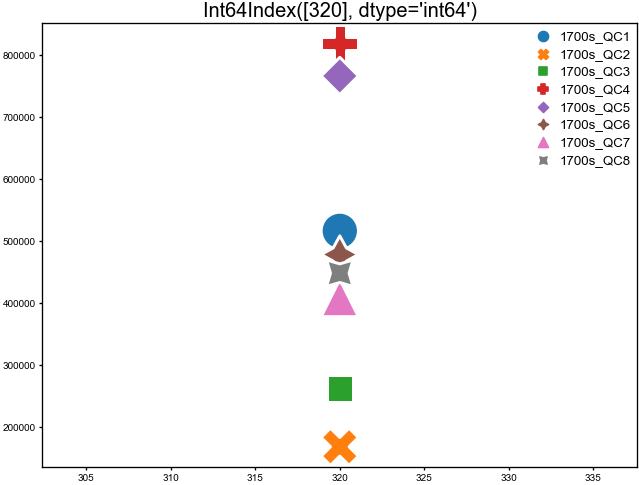

In [281]:
random_feature = rawqc.sample(1).index
sns.scatterplot(data=rawqc.loc[random_feature], s=500, marker='o')
plt.title(random_feature)

In [144]:
vdata = np.log2(cd.loc[:, rename2.values()])
extra_stuff = cd.iloc[:, :cd.columns.to_list().index('MS2')]
vdata = extra_stuff.join(vdata)
vdata

,ID,in_original,is_lipid,is_junk,is_dubious,Annot. DeltaMass [ppm],Calc. MW,m/z,RT,adduct,...,1700s_QC4,1700s_QC5,1700s_QC6,1700s_QC7,1700s_QC8,1700s_QCdil_150,1700s_QCdil_200,1700s_resuspension_blank_rep1,1700s_water_blank_rep1,1700s_water_blank_rep2
0,NaN,NaN,NaN,NaN,NaN,NaN,84.03107,83.02379,0.240,[M-H]-1,...,21.381361,30.017244,25.721532,25.620402,26.526276,25.970559,25.560817,19.676096,21.031353,18.918997
1,NaN,NaN,1.0,NaN,NaN,-4.18,510.33875,509.33147,1.300,[M-H]-1,...,22.712742,20.866109,21.180690,21.692261,21.718728,23.428032,23.053324,16.516584,17.025070,17.340864
2,NaN,NaN,1.0,NaN,NaN,-1.17,368.34387,369.35115,1.329,[M+H]+1,...,22.022570,20.215617,21.266970,21.382422,22.030310,21.456587,19.523454,15.675954,16.191938,16.417178
3,NaN,NaN,1.0,NaN,NaN,NaN,871.76122,872.76849,1.330,[M+H]+1,...,19.996507,18.798282,19.973698,20.627591,20.751220,20.457872,17.751225,15.997038,16.513023,16.738263
4,Cholesterol sulfate,NaN,1.0,NaN,NaN,1.63,466.31244,465.30516,1.389,[M-H]-1,...,27.291539,25.554985,25.679044,26.116711,26.342266,27.153465,26.319476,16.651364,17.242704,17.522161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,NaN,NaN,NaN,NaN,NaN,1.25,228.10861,227.10133,18.268,[M-H]-1,...,19.757360,18.383321,20.464944,20.649165,20.683358,21.505963,21.755709,15.945249,15.908060,15.920376
432,NaN,NaN,NaN,NaN,NaN,NaN,146.10463,145.09734,18.271,[M-H]-1,...,22.053287,21.295241,22.622541,22.425076,22.416959,23.269041,23.642443,17.672595,15.483705,17.999694
433,Arginine,1.0,NaN,NaN,NaN,-0.56,174.11158,175.11894,18.711,[M+H]+1,...,24.344776,23.971925,23.088730,22.614651,22.621704,24.661192,25.188921,20.291128,16.736492,21.732980
434,NaN,1.0,NaN,NaN,NaN,-8.00,132.08882,131.08154,18.724,[M-H]-1,...,20.362964,20.444197,20.644126,19.858949,20.152270,21.422806,21.917545,15.116739,14.586511,18.663467


In [148]:
oids = data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified')]
oids

# vdata.loc[vdata['ID'].str.lower().isin(oids['ID'].str.lower().to_list())]

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,...,0.748819,0.233844,0.104163,True,NaN,NaN,NaN,NaN,NaN,ns
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,...,9.482876,0.889251,0.159312,True,NaN,NaN,NaN,NaN,NaN,ns
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,...,0.459055,1.250723,0.480416,True,NaN,NaN,NaN,NaN,NaN,ns
m_5,Tyrosine_11.137_180.0656,Tyrosine,180.06563,11.137,Amino acid,metabolite,-,HILIC,Amino acid,23.065294,...,2.977319,1.403552,0.104163,True,NaN,NaN,NaN,NaN,NaN,ns
m_6,Tryptophan_9.861_203.0817,Tryptophan,203.08170,9.861,Amino acid,metabolite,-,HILIC,Amino acid,22.586018,...,3.488614,0.752468,0.268424,True,NaN,NaN,NaN,NaN,NaN,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_133,3-Methylhistidine_11.492_170.0924,3-Methylhistidine,170.09239,11.492,Amino acid derivative,metabolite,+,HILIC,Amino acid derivative,20.736758,...,20.095417,0.868828,0.494541,True,NaN,NaN,NaN,NaN,NaN,ns
m_135,Indoxyl sulfate_8.177_212.0014,Indoxyl sulfate,212.00143,8.177,Organic acid,metabolite,-,HILIC,Organic acid,20.507605,...,1.286151,0.840874,0.921479,True,NaN,NaN,NaN,NaN,NaN,ns
m_136,3-Hydroxybutyric acid_9.527_103.0389,3-Hydroxybutyric acid,103.03895,9.527,Organic acid,metabolite,-,HILIC,Organic acid,26.065942,...,11.916771,0.272466,1.769866,True,NaN,NaN,NaN,NaN,NaN,*


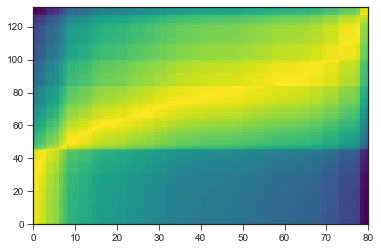

In [32]:
# v_rt = vids['RT [min]'].sort_values().values
# o_rt = oids['RT'].sort_values().values

# rt_diffs = abs(np.subtract.outer(v_rt, o_rt))

# plt.pcolormesh(rt_diffs, cmap='viridis_r')

In [ ]:
for o, orow in oids.iterrows():
    for v, vrow in vids.iterrows():
        print(abs())

In [153]:
oids[['ID', 'RT', 'm/z']].sort_values('ID').to_clipboard()

In [224]:
test = cd.filter(regex='QCdil').iloc[10]
test

1700s_QCdil_025    6.368797e+06
1700s_QCdil_050    1.310220e+07
1700s_QCdil_100    9.901998e+06
1700s_QCdil_150    1.234527e+07
1700s_QCdil_200    7.334925e+06
Name: 10, dtype: float64

In [222]:
[x for x in cd.columns]

['ID',
 'in_original',
 'is_lipid',
 'is_junk',
 'is_dubious',
 'Annot. DeltaMass [ppm]',
 'Calc. MW',
 'm/z',
 'RT',
 'adduct',
 'Area (Max.)',
 'Formula',
 'mzCloud Best Match',
 'Annot. Source: Predicted Compositions',
 'Annot. Source: mzCloud Search',
 '# mzCloud Results',
 'Annot. Source: Metabolika Search',
 'Annot. Source: ChemSpider Search',
 '# ChemSpider Results',
 'mzCloud Best Match Confidence',
 'mzCloud Best Sim. Match',
 'mzCloud Best Tree Match',
 'MS2',
 '1731_30_RBG',
 '1731_31_RBG',
 '1731_32_RBG',
 '1742_32_RBG',
 '1742_33_RBG',
 '1742_34_RBG',
 '1743_31_RBG',
 '1743_32_RBG',
 '1743_33_RBG',
 '1746_30_RBG',
 '1746_31_RBG',
 '1746_32_RBG',
 '1748_29_RBG',
 '1748_30_RBG',
 '1748_31_RBG',
 '1754_30_RBG',
 '1754_31_RBG',
 '1754_32_RBG',
 '1788_34_RBG',
 '1789_34_RBG',
 '1810_31_RBG',
 '1811_31_RBG',
 '1812_31_RBG',
 '1700s_extract_blank_rep3',
 '1727_27_RBG',
 '1727_28_RBG',
 '1727_29_RBG',
 '1728_27_RBG',
 '1728_28_RBG',
 '1728_30_RBG',
 '1732_27_RBG',
 '1732_28_RBG',


# Filter out lipids from HILIC run

<AxesSubplot:xlabel='RT', ylabel='m/z'>

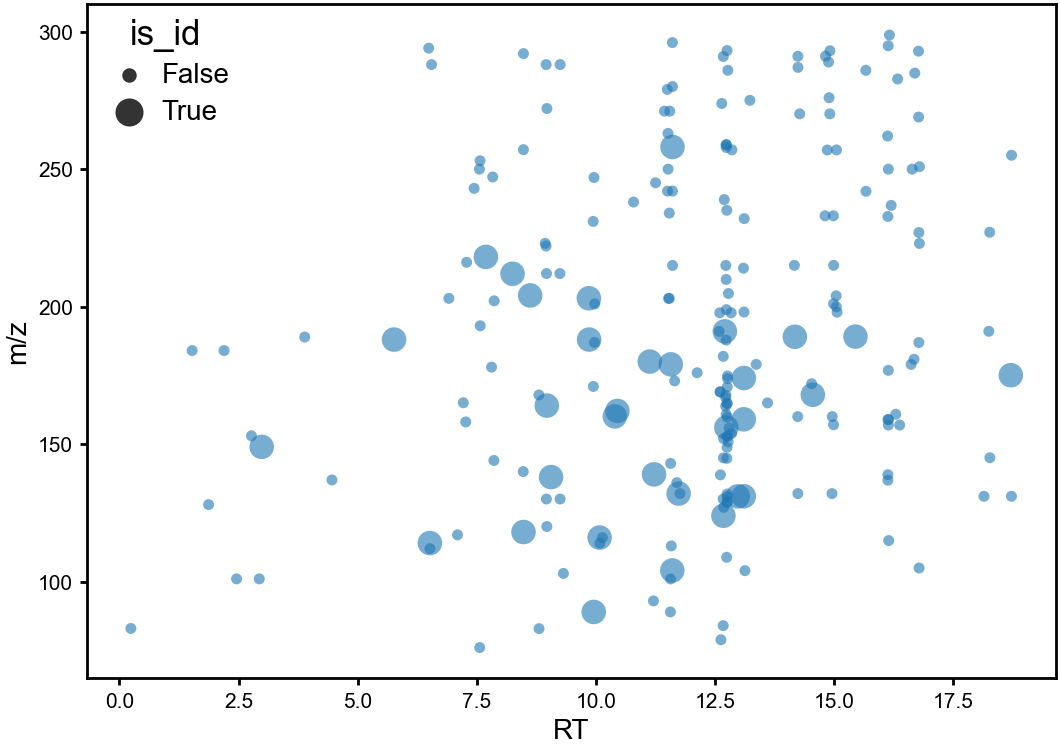

In [219]:
cd['is_id'] = cd['ID'].notna()
fig, ax = plt.subplots(dpi=250, figsize=(5, 3.5))
sns.scatterplot(
    data=cdf,#.loc[cd['ID'].notna()], 
    x='RT', y='m/z', size='is_id', sizes={True: 50, False: 10},
    linewidth=0, alpha=0.6
)

In [218]:
cdf = cd.loc[~((cd['RT'] < 5) & (cd['m/z'] > 200))]
cdf = cdf.loc[cdf['m/z'] < 300]
cdf['ID'].notna().sum()

32

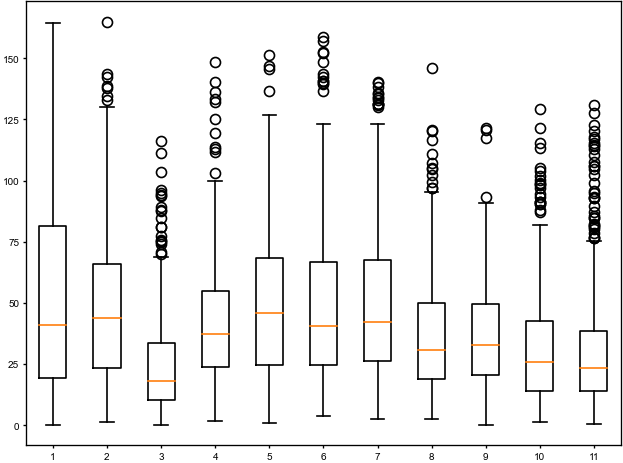

In [220]:
valsamps = fg.loc[fg['validation']].index
valgb = (cd
 .loc[:, 
#      cd['ID'].notna(), 
     valsamps
 ]
 .T
 .groupby(fg['animal'])
)
valgb
valrsd = ((valgb.std() / valgb.mean()) * 100).T
# valrsd.T.plot(kind='kde')
plt.boxplot(valrsd);

In [178]:
cd[].T

,0,1,2,3,4,5,6,7,8,9,...,426,427,428,429,430,431,432,433,434,435
1727_27_RBG,2.411535e+07,2.532307e+06,1.680530e+06,5.003159e+05,1.008486e+08,2.924838e+07,5.849067e+06,8.595517e+06,5.374357e+06,1.000019e+07,...,16174.201176,19385.201270,23241.378419,2.153049e+06,7.070630e+05,8.693066e+05,3.284809e+06,7.809827e+06,2.463406e+06,4.173833e+05
1727_28_RBG,6.706778e+07,2.620280e+06,2.527482e+06,2.834051e+06,1.077392e+08,7.411259e+07,5.436979e+06,8.861873e+06,4.049395e+06,9.539985e+06,...,15665.552202,19290.308684,23439.329677,2.719206e+06,1.147483e+06,1.552332e+06,5.190919e+06,6.808585e+06,3.054613e+06,4.070922e+05
1727_29_RBG,2.101696e+07,4.224273e+06,4.099762e+06,2.115829e+06,1.299220e+08,2.566577e+07,4.701423e+06,1.160707e+07,4.053125e+06,9.516815e+06,...,31583.242544,19811.110650,24962.708701,2.666157e+06,8.971888e+05,7.655702e+05,3.540450e+06,2.253818e+07,1.752216e+06,1.060016e+06
1728_27_RBG,2.908331e+07,4.485619e+06,1.409342e+06,1.669076e+06,1.292758e+08,3.669786e+07,8.850404e+06,1.046840e+07,1.350753e+07,2.024647e+07,...,44820.371976,19868.582673,24376.099177,4.411591e+06,1.533059e+06,1.404932e+06,6.156343e+06,3.565370e+07,4.491245e+06,1.830677e+06
1728_28_RBG,5.141453e+06,5.417449e+06,2.164030e+06,3.510462e+06,1.743337e+08,1.361367e+08,1.210953e+07,1.194863e+07,1.585393e+07,2.617479e+07,...,30099.727987,25207.023816,23981.821527,2.287341e+06,1.293189e+06,5.596139e+05,3.528144e+06,2.148878e+07,2.268329e+06,8.097680e+05
1728_30_RBG,2.635409e+07,3.315587e+06,1.381642e+06,5.086202e+06,1.042555e+08,8.761952e+07,5.577828e+06,7.864471e+06,1.078207e+07,1.627218e+07,...,16021.161577,19258.663152,127987.588334,1.865593e+06,7.775059e+05,9.288929e+05,3.320318e+06,4.327618e+06,5.563410e+05,2.248428e+05
1731_30_RBG,1.926643e+07,4.040218e+06,2.882772e+06,9.833010e+05,9.981668e+07,2.570002e+07,3.423910e+06,4.771641e+06,3.504477e+06,8.525683e+06,...,16042.445541,19211.909865,22801.314152,1.774449e+06,1.099546e+06,1.238240e+06,4.290526e+06,5.570675e+06,1.815775e+06,3.663830e+05
1731_31_RBG,6.123060e+07,5.291336e+06,2.638314e+06,5.046735e+05,9.781670e+07,2.450624e+07,5.183379e+06,8.941757e+06,7.383969e+06,1.241160e+07,...,16429.883033,19280.052892,60763.149431,1.834240e+06,9.134457e+05,1.130748e+06,3.983783e+06,5.919155e+06,1.079430e+06,3.474530e+05
1731_32_RBG,1.282484e+07,4.578294e+06,7.969370e+06,1.402849e+06,8.093426e+07,2.635263e+07,3.348139e+06,1.104283e+07,4.717466e+06,9.090854e+06,...,16432.674910,19182.256885,161870.952735,1.099680e+06,9.532003e+05,4.861848e+05,2.283526e+06,1.397402e+07,1.082658e+06,4.261128e+05
1732_27_RBG,3.135936e+07,4.970241e+06,6.872278e+06,6.352222e+05,1.083252e+08,3.676384e+07,5.592919e+06,1.221378e+07,5.947485e+06,1.310069e+07,...,15713.361227,19316.271497,75224.889488,1.822462e+06,7.737228e+05,7.403431e+05,3.169259e+06,8.029547e+06,7.509525e+05,4.235949e+05


In [171]:
cd.loc[:, cd.columns.str.match('10')]

,1061_8_RBG,1061_9_RBG,1061_10_RBG,1075_8_RBG,1075_9_RBG,1075_10_RBG,1081_8_RBG,1081_9_RBG,1081_10_RBG,1094_8_RBG,1094_9_RBG,1094_10_RBG,1095_8_RBG,1095_9_RBG,1095_10_RBG,1096_8_RBG,1096_9_RBG,1096_10_RBG
0,1.142148e+07,1.062844e+07,2.946385e+07,7.132755e+07,3.486157e+07,1.608727e+07,1.631490e+07,3.517666e+07,1.646252e+07,1.154087e+07,2.899825e+07,8.749529e+06,1.056235e+07,3.148952e+07,3.857841e+07,4.145228e+07,1.236667e+07,7.371173e+06
1,1.334576e+06,3.337607e+05,2.002355e+06,1.188010e+06,6.831720e+05,3.678813e+05,1.182665e+06,3.169454e+05,7.161337e+05,5.947318e+05,1.529602e+05,1.326110e+05,7.608714e+05,2.083020e+06,2.219850e+05,2.554684e+06,8.528542e+05,8.880104e+04
2,9.298519e+06,1.208348e+07,1.724399e+07,1.556863e+07,1.143483e+07,7.643184e+06,2.673014e+07,1.944768e+06,6.037675e+06,1.235052e+07,1.257847e+05,6.788283e+05,9.052731e+06,1.229486e+07,9.371367e+04,2.175381e+07,3.044439e+06,2.886851e+05
3,4.199780e+05,1.786486e+05,1.770726e+06,1.505988e+06,6.048678e+05,1.268527e+05,2.866746e+06,1.272497e+05,2.244528e+05,1.161121e+05,1.571390e+05,1.397322e+05,9.565879e+04,2.257844e+05,1.170736e+05,5.216424e+05,1.563748e+05,1.726012e+05
4,2.985360e+07,2.139952e+07,7.022756e+07,7.579534e+07,3.675129e+07,4.169330e+07,7.270121e+07,1.061185e+07,5.777981e+06,2.407377e+07,3.719480e+05,2.286636e+06,2.051197e+07,3.772362e+07,4.463630e+05,5.410120e+07,3.536842e+07,1.071549e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,3.176842e+06,1.156263e+06,2.997876e+06,1.984017e+06,1.680052e+06,2.208283e+06,2.241988e+06,2.759770e+05,2.266948e+06,3.035042e+06,4.312576e+04,6.486070e+05,2.910172e+06,2.979356e+06,6.127883e+04,4.171190e+06,2.628468e+06,1.185909e+05
432,1.043835e+07,2.860738e+06,9.538302e+06,5.624506e+06,4.192030e+06,6.183350e+06,6.904380e+06,1.663815e+06,7.734378e+06,9.751107e+06,1.662211e+05,1.562265e+06,8.811839e+06,1.029998e+07,2.415585e+05,1.755589e+07,8.604600e+06,3.710875e+05
433,4.687911e+06,1.233501e+06,1.013734e+07,6.717423e+05,6.349629e+05,1.895785e+06,5.580938e+05,4.910951e+05,2.640706e+06,1.880472e+06,3.279450e+05,1.822707e+06,5.779276e+05,7.656805e+05,5.486920e+05,6.305753e+06,8.036851e+06,6.801407e+05
434,3.375521e+06,1.388125e+06,3.399140e+06,2.623816e+06,2.405685e+06,2.704306e+06,2.962774e+06,7.831373e+05,2.846915e+06,3.254591e+06,5.566043e+04,1.021189e+06,2.851310e+06,3.330476e+06,3.488127e+04,5.248591e+06,2.648848e+06,2.742518e+05


(array([129., 247., 330., 434., 597., 417., 168., 127., 113.,  54.]),
 array([  1.2598918 ,  18.32594468,  35.39199755,  52.45805042,
         69.5241033 ,  86.59015617, 103.65620905, 120.72226192,
        137.78831479, 154.85436767, 171.92042054]),
 <BarContainer object of 10 artists>)

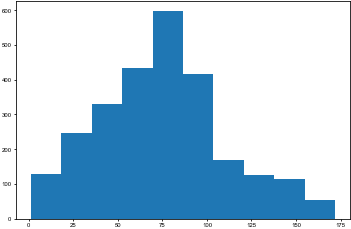

In [170]:
testgb = cd.loc[:, cd.columns.str.match('10')].T.join(fg['animal']).groupby('animal')
testrsd = (testgb.std() / testgb.mean()) * 100
plt.hist(testrsd.values.ravel())

In [159]:
[x for x in cd.columns]

['ID',
 'in_original',
 'is_lipid',
 'is_junk',
 'is_dubious',
 'Annot. DeltaMass [ppm]',
 'Calc. MW',
 'm/z',
 'RT',
 'adduct',
 'Area (Max.)',
 'Formula',
 'mzCloud Best Match',
 'Annot. Source: Predicted Compositions',
 'Annot. Source: mzCloud Search',
 '# mzCloud Results',
 'Annot. Source: Metabolika Search',
 'Annot. Source: ChemSpider Search',
 '# ChemSpider Results',
 'mzCloud Best Match Confidence',
 'mzCloud Best Sim. Match',
 'mzCloud Best Tree Match',
 'MS2',
 '1731_30_RBG',
 '1731_31_RBG',
 '1731_32_RBG',
 '1742_32_RBG',
 '1742_33_RBG',
 '1742_34_RBG',
 '1743_31_RBG',
 '1743_32_RBG',
 '1743_33_RBG',
 '1746_30_RBG',
 '1746_31_RBG',
 '1746_32_RBG',
 '1748_29_RBG',
 '1748_30_RBG',
 '1748_31_RBG',
 '1754_30_RBG',
 '1754_31_RBG',
 '1754_32_RBG',
 '1788_34_RBG',
 '1789_34_RBG',
 '1810_31_RBG',
 '1811_31_RBG',
 '1812_31_RBG',
 '1700s_extract_blank_rep3',
 '1727_27_RBG',
 '1727_28_RBG',
 '1727_29_RBG',
 '1728_27_RBG',
 '1728_28_RBG',
 '1728_30_RBG',
 '1732_27_RBG',
 '1732_28_RBG',


## Parse columns

In [149]:
cols = cd.filter(regex='^Area: ')
for col in cols: 
    if 'wk' in col: 
        split = col.split('_')
        animal = split[2][:-1]
        sex = split[2][-1]
        week = int(split[3][:-2])
        long_name = col.split(' ')[1][:-4]
        short_name = f'{animal}_{week}_RBG' 
        fg.loc[short_name, 'File Name_metab'] = long_name
    else:
        print(col)

Area: BJA-Nilerat-20220921_extract_blank_rep2_220922112331.raw (F61)
Area: BJA-Nilerat-20220921_metab_1000s_extract_blank_rep1.raw (F62)
Area: BJA-Nilerat-20220921_metab_1000s_extract_blank_rep2.raw (F63)
Area: BJA-Nilerat-20220921_metab_1000s_QC25uL_dil.raw (F64)
Area: BJA-Nilerat-20220921_metab_1000s_QC50uL_dil.raw (F65)
Area: BJA-Nilerat-20220921_metab_1000s_QC100uL_dil.raw (F66)
Area: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep1.raw (F67)
Area: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep2.raw (F68)
Area: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep3.raw (F69)
Area: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep4.raw (F70)
Area: BJA-Nilerat-20220921_metab_1000s_QC150uL_dil.raw (F71)
Area: BJA-Nilerat-20220921_metab_1000s_QC200uL_dil.raw (F72)
Area: BJA-Nilerat-20220921_metab_1000s_water_blank_rep1.raw (F73)
Area: BJA-Nilerat-20220921_metab_resuspension_blank_rep1.raw (F92)


## Parse run order

In [119]:
# order = {}
# existing_files = fg.loc[fg['validation'], 'File Name_metab'].dropna().values
# for file in Path('../data/raw/metabolomics/raw files').glob('*.raw'):
#     if 'BJA' not in str(file):
#         continue
# #     print(file.stat().st_mtime)
# #     print(file.stem)
#     order[file.stem] = file.stat().st_mtime
# order = pd.Series(order).sort_values().rank().to_frame().reset_index()
# order = order.loc[order['index'].isin(existing_files)]
# order[0] = order[0].rank()
# order.index = order['index']
# order.loc[existing_files, 0].to_clipboard()
# # (order.values[1:] - order.values[:-1])/60


# Figure out which features are the heavy labeled amino acids 

### Does CD filter out the heavy labeled AA features? 

https://www.sigmaaldrich.com/specification-sheets/850/784/909653-BULK_______ALDRICH__.pdf

A Ala Alanine-13C3,15N 


R Arg Arginine-13C6,15N4


N Asn Asparagine-15N2


D Asp Aspartic acid-13C4,15N


C Cystine Cystine-d4

Q Gln Glutamine-15N2

E Glu Glutamic acid-13C5, 15N

G Gly Glycine-13C2,15N

H His Histidine-15N3

I Ile Isoleucine-13C6, 15N

L Leu Leucine-13C6

K Lys Lysine-13C6,15N2

M Met Methionine-13C5,15N


F Phe Phenylalanine-13C9,15N

P Pro Proline-13C5,15N

S Ser Serine-13C3,15N

T Thr Threonine-13C4, 15N

W Trp Tryptophan-15N2

Y Tyr Tyrosine-13C9,15N

V Val Valine-13C5,15N

In [331]:
import molmass 

Hmass = molmass.Formula('H').isotope.mass
water = molmass.Formula('H2O').isotope.mass
nh2 =   molmass.Formula('NH2').isotope.mass
Omass = molmass.Formula('O').isotope.mass
Cmass = molmass.Formula('C').isotope.mass
C13mass = molmass.Formula('(13C)').isotope.mass
N15mass = molmass.Formula('(15N)').isotope.mass
aa = {
    'G': ('C2H3NO',   '[13C]2 H3 (15N)   O'),
    'P': ('C5H7NO',   '[13C]5 H7 (15N)   O'   ),
    'A': ('C3H5NO',   '[13C]3 H5 (15N)   O'   ),
    'V': ('C5H9NO',   '[13C]5 H9 (15N)   O'   ),
    'L': ('C6H11NO',  '[13C]6 H11 N      O'    ),
    'I': ('C6H11NO',  '[13C]6 H11 (15N)  O'    ),
    'M': ('C5H9NOS',  '[13C]5 H9 (15N)   O S'    ),
    'C': ('C3H5NOS',  'C3     D4 H1 N    O S'    ),
    'F': ('C9H9NO',   '[13C]9 H9 (15N)   O'   ),
    'Y': ('C9H9NO2',  '[13C]9 H9 (15N)   O'    ),
    'W': ('C11H10N2O','C11    H10 (15N)2 O'   ),
    'H': ('C6H7N3O',  'C6     H7 (15N)3  O'   ),
    'K': ('C6H12N2O', '[13C]6 H12 (15N)2 O'    ),
    'R': ('C6H12N4O', '[13C]6 H12 (15N)4 O'    ),
    'Q': ('C5H8N2O2', 'C5     H8 [15N]2  O2'    ),
    'N': ('C4H6N2O2', 'C4     H6 [15N]2  O2'    ),
    'E': ('C5H7NO3',  '[13C]5 H8 [15N]   O3'   ),
    'D': ('C4H5NO3',  '[13C]4 H5 [15N]   O3'   ),
    'S': ('C3H5NO2',  '[13C]3 H5 [15N]   O2'   ),
    'T': ('C4H7NO2',  '[13C]4 H7 [15N]   O2'   ),
}

(molmass.Formula(aa['C'][1]) + molmass.Formula('H2O')).formula
molmass.Formula(aa['H'][1]).isotope.mass + nh2 

156.06874061071002

In [143]:
for letter in aa:
    print(letter, 
          np.isclose(
              cd['m/z'], 
              molmass.Formula(aa[letter][0]).isotope.mass + water + Hmass - Cmass + C13mass, 
              rtol=10e-6).sum())

G 0
P 0
A 0
V 0
L 0
I 0
M 0
C 0
F 0
Y 0
W 0
H 0
K 0
R 0
Q 0
N 0
E 0
D 0
S 0
T 0
